In [1]:
import os
import sys
import glob
import math
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import pydicom
from pydicom.pixel_data_handlers.util import convert_color_space
import cv2
from PIL import Image

In [2]:
# Given a filename, use the extension to determine if it is an image
PIL_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.tif', '.tiff']
ALL_EXTENSIONS = PIL_EXTENSIONS + ['.dcm']
def is_img_ext(filename: str) -> bool:
    return os.path.splitext(filename)[1].lower() in ALL_EXTENSIONS

In [3]:
# Given a path and optional glob string, return the list of files in
# the directory. Also, optionally filter by image extension.
def get_file_list(path: str, glob_str: str = "*.*", filter_images=True) -> list:
    if os.path.isfile(path):
        if glob_str:
            print('Warning: glob string ignored for single file input')
        return [path]

    if not path.endswith('/'):
        path += '/'
    filelist = glob.glob(path + glob_str)

    if filter_images:
        filelist = [file for file in filelist if is_img_ext(file)]

    return filelist

In [4]:
def fix_missing_PixelRep(ds):
    if not 'PixelRepresentation' in ds:
        ds.PixelRepresentation = 0
        return ds

In [5]:
def get_image_rev(filename: str, rgb_to_gray=True, verbose=False):
    rgb_flag = False
    ext = os.path.splitext(filename)[1].lower()
    if ext == '.dcm':
        dicom_data = pydicom.read_file(filename)
        if not 'PixelRepresentation' in dicom_data:
            dicom_data.PixelRepresentation = 0
            if verbose:
                print(f'Added PixelRep = 0 for {os.path.basename(filename)}')
        im = dicom_data.pixel_array
        # Debug
        if verbose:
            print(dicom_data)
            print(f'pixel_array = \n{im}')
            print(f'PhotoInterp = {dicom_data.PhotometricInterpretation}')
        if dicom_data.PhotometricInterpretation == 'MONOCHROME1':
            im = im.max() - im
        elif dicom_data.PhotometricInterpretation == 'MONOCHROME2':
            pass  #"standard" case
        elif dicom_data.PhotometricInterpretation == 'RGB':
            rgb_flag = True
        elif dicom_data.PhotometricInterpretation == 'YBR_FULL_422':
            im = convert_color_space(im, "YBR_FULL_422", "RGB")
            print(f'ybr converted to rgb')
            rgb_flag = True
        else:
            print(f"WARNING: Unexpected PhotometricInterpretation = {dicom_data.PhotometricInterpretation}")
            
        im_shape = im.shape
    elif ext in PIL_EXTENSIONS:
        im = Image.open(filename)
        im_shape = im.size
        rgb_flag = True
    else:
        print(f"file not in {PIL_EXTENSIONS}")
        
    if rgb_flag and rgb_to_gray:
        if im.max(axis=2).all() == im.min(axis=2).all():
            im = im.max(axis=2)
            print(f'RGB converted to grayscale')
        else:
            print(f"ERROR: RGB components differ; not grayscale")
        im_shape = im.shape

    return im, im_shape

In [6]:
def get_inputs(path=None, glob_str=None):
    if not path:
        path = input("Enter full image directory path: ")
    if not glob_str:
        glob_str = input("Enter glob string: ")

    return path, glob_str

In [7]:
def display_batch(filelist: list, grid_shape: tuple):
    fsize = (grid_shape[1] * 6, grid_shape[0] * 4)
    fig, axs = plt.subplots(grid_shape[0], grid_shape[1], figsize=fsize)
    for ax, file in zip(axs, filelist):
#        print(f'file: {file}')
        basename = os.path.basename(file)
        img, im_shape = get_image_rev(file)
        #img, im_shape = get_image_rev(file, verbose=True)
        ax.set_title(basename)
        ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.set_xlabel(im_shape[1])
        ax.set_ylabel(im_shape[0])
        ax.imshow(img, cmap=plt.cm.bone)
    plt.show()

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.2.1470482042.4044.1537951425151.1011
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.2.1470482042.4044.1537951425151.1011
(0008, 0020) Study Date                          DA: '20170518'
(0008, 0021) Series Dat

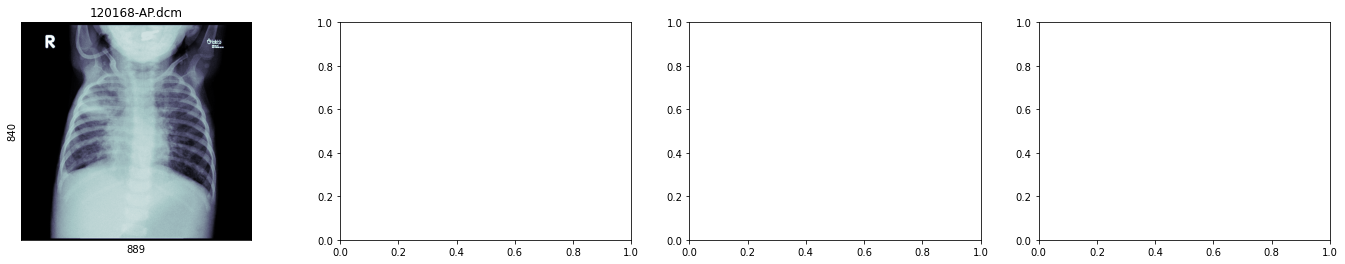

In [8]:
index = 0
#path='/slurm_storage/mbopf/data/PedTB/renamed'
path='/slurm_storage/mbopf/projects/mwb/imaging_utils'
glob_str='12*.dcm'
#glob_str='11*.dcm'
#glob_str='05*.dcm'
#path, glob_str = get_inputs()
grid_shape = (1,4)
grid_size = grid_shape[0] * grid_shape[1] 
full_list = get_file_list(path, glob_str, filter_images=False)
#filelist = get_file_list(path) # Defaults of all files and image types
display_batch(full_list[index:index+grid_size], grid_shape)

In [9]:
index += grid_size
print(f'index: {index}; len(full_list): {len(full_list)}')
if index < len(full_list):
    display_batch(full_list[index:index+grid_size], grid_shape)
else:
    print(f'index: {index}; len(full_list): {len(full_list)}')

index: 4; len(full_list): 1
index: 4; len(full_list): 1


In [10]:
# Remove black boundaries
# NOTE: this code *assumes* that img.max() is White, so if the image is reversed (e.g., 
#       PixelRepresentation: MONOCHROME1) this code will fail. Please pass a "normal" 
#       grayscale image.
def crop_image(img):
    # threshold using the OTSU algorithm
    thresh = cv2.threshold(img, 0, img.max(), cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    hh, ww = thresh.shape

    white = np.where(thresh==img.max())
    xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])

    return(img[ymin:ymax, xmin:xmax])

In [11]:
def display_cropped_batch(filelist: list, grid_shape: tuple):
    fsize = (grid_shape[1] * 6, grid_shape[0] * 4)
    fig, axs = plt.subplots(grid_shape[0], grid_shape[1], figsize=fsize)
    for ax, file in zip(axs, filelist):
        print(f'file: {file}')
        basename = os.path.basename(file)
        img, im_shape = get_image_rev(file)
        img = crop_image(img)
        ax.set_title(basename)
        ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.set_xlabel(im_shape[1])
        ax.set_ylabel(im_shape[0])
        ax.imshow(img, cmap=plt.cm.bone)
    plt.show()

file: /slurm_storage/mbopf/data/PedTB/renamed/0522100-AP.dcm
RGB converted to grayscale
file: /slurm_storage/mbopf/data/PedTB/renamed/0522100-LAT.dcm
RGB converted to grayscale
file: /slurm_storage/mbopf/data/PedTB/renamed/0522112-AP.dcm
RGB converted to grayscale
file: /slurm_storage/mbopf/data/PedTB/renamed/0522112-LAT.dcm
RGB converted to grayscale


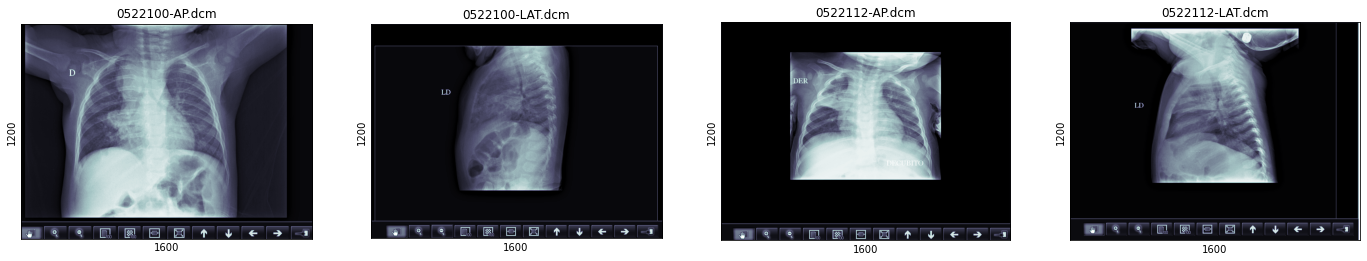

In [12]:
index = 0
path='/slurm_storage/mbopf/data/PedTB/renamed'
#path='/slurm_storage/mbopf/projects/mwb/imaging_utils'
#glob_str='*.dcm'
#glob_str='11*.dcm'
glob_str='05*.dcm'
#path, glob_str = get_inputs()
grid_shape = (1,4)
grid_size = grid_shape[0] * grid_shape[1] 
full_list = get_file_list(path, glob_str, filter_images=False)
#filelist = get_file_list(path) # Defaults of all files and image types
display_cropped_batch(full_list[index:index+grid_size], grid_shape)

index: 4; len(full_list): 52
file: /slurm_storage/mbopf/data/PedTB/renamed/0522124-AP.dcm
RGB converted to grayscale
file: /slurm_storage/mbopf/data/PedTB/renamed/0522124-LAT.dcm
RGB converted to grayscale
file: /slurm_storage/mbopf/data/PedTB/renamed/0522184-AP.dcm
RGB converted to grayscale
file: /slurm_storage/mbopf/data/PedTB/renamed/0522184-LAT.dcm
RGB converted to grayscale


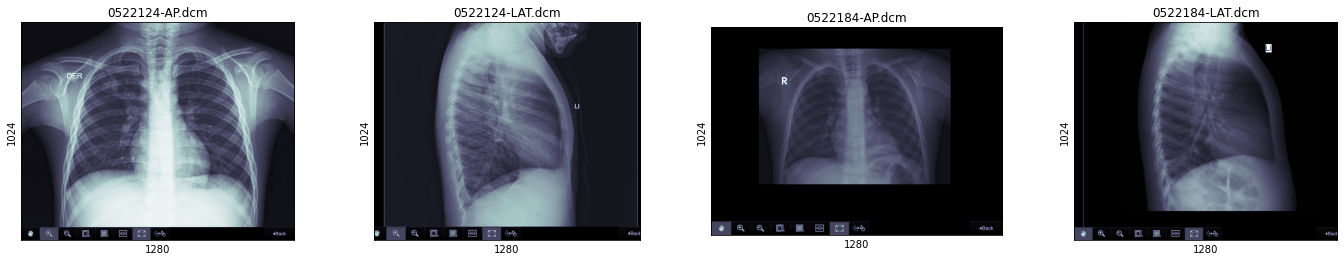

In [13]:
index += grid_size
print(f'index: {index}; len(full_list): {len(full_list)}')
if index < len(full_list):
    display_cropped_batch(full_list[index:index+grid_size], grid_shape)
else:
    print(f'index: {index}; len(full_list): {len(full_list)}')